In [ ]:
import os
import gc
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score as ras
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import lightgbm as lgb
import xgboost as xgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/SisFall_Preprocessed/'

In [ ]:
users = pd.read_csv(os.path.join(PATH, 'user_details.csv'))
feats = pd.read_csv(os.path.join(PATH, 'user_compressed_feats.csv'),)

sub = pd.DataFrame(feats[['user_test', 'target']].values, columns=['user_test','target'])
sub['target'] = sub['target'].astype(int)
sub['prediction'] = 0

print(f'Data Shape : {feats.shape}')

Data Shape : (4447, 29)


In [ ]:
feats['user_id'] = feats['user_test'].apply(lambda x:x.split('_')[1])
feats = feats.merge(users, how='left', on='user_id')
feats['gender'] = feats['gender'].map({'M':0,'F':1})

use_cols = [x for x in feats.columns if x not in ['user_test','user_id','target']]

In [ ]:
feats.head()

,user_test,sum_C0,mean_C0,std_C0,sum_C1,mean_C1,std_C1,sum_C2,mean_C2,std_C2,sum_C3,mean_C3,std_C3,sum_C4,mean_C4,std_C4,sum_C5,mean_C5,std_C5,sum_C6,mean_C6,std_C6,sum_C7,mean_C7,std_C7,sum_C8,mean_C8,std_C8,target,user_id,age,height,weight,gender
0,D12_SA01_R04.txt,-305202.0,-127.167500,121.615248,-397540.0,-165.641667,94.263054,2517.0,1.048750,25.960493,-68428.0,-28.511667,111.053110,60237.0,25.09875,157.082555,-11128.0,-4.636667,336.317063,-1185583.0,-493.992917,471.549925,-1537463.0,-640.609583,369.526430,314525.0,131.052083,95.799792,0,SA01,26.0,165.0,53.0,1.0
1,D14_SA01_R05.txt,292954.0,122.064167,121.333521,-737.0,-0.307083,31.299831,340142.0,141.725833,92.096443,-116420.0,-48.508333,149.153422,36555.0,15.23125,435.055552,8792.0,3.663333,117.404773,1128874.0,470.364167,463.540138,-6551.0,-2.729583,123.397997,1671455.0,696.439583,374.545569,0,SA01,26.0,165.0,53.0,1.0
2,D14_SA01_R02.txt,-258286.0,-107.619167,132.607431,-56660.0,-23.608333,23.748560,310273.0,129.280417,107.104615,-103645.0,-43.185417,155.422136,41451.0,17.27125,502.259205,-21041.0,-8.767083,149.830033,-999109.0,-416.295417,517.392270,-221131.0,-92.137917,93.802002,1568284.0,653.451667,428.172743,0,SA01,26.0,165.0,53.0,1.0
3,D17_SA01_R04.txt,-109386.0,-21.877200,24.578749,-1161355.0,-232.271000,18.500766,97741.0,19.548200,78.004944,-30814.0,-6.162800,268.670483,532264.0,106.45280,399.896366,-907.0,-0.181400,126.266457,-468355.0,-93.671000,94.672133,-4429972.0,-885.994400,71.284085,885057.0,177.011400,308.837236,0,SA01,26.0,165.0,53.0,1.0
4,F02_SA01_R04.txt,72877.0,24.292333,71.923730,-450492.0,-150.164000,177.814292,153816.0,51.272000,180.494596,163172.0,54.390667,637.437903,497076.0,165.69200,516.069290,10970.0,3.656667,330.487391,44147.0,14.715667,277.981864,-1700732.0,-566.910667,653.473849,1112249.0,370.749667,711.701931,1,SA01,26.0,165.0,53.0,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


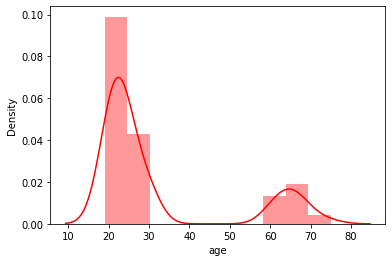

In [ ]:
import seaborn as sns
sns.distplot(feats['age'], color='red', bins=10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


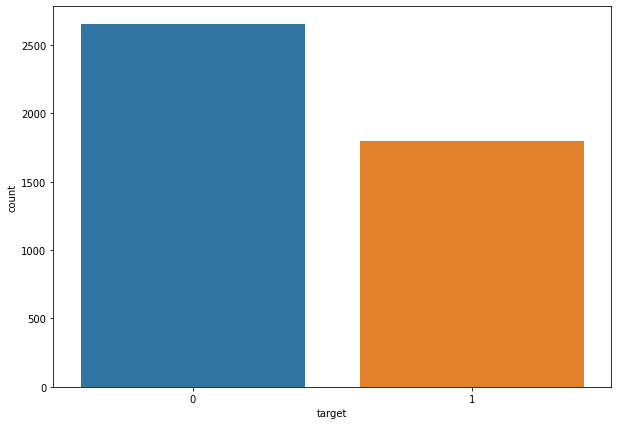

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize =(10, 7))
sns.countplot(feats['target'])

LightGBM

In [ ]:
init_params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
          'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
          'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
          'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
          'min_split_gain': 0.5, 'min_child_weight': 1, 
          'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
          'metric': 'binary_error',
          'verbosity':0}

In [ ]:
init_params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
          'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
          'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
          'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
          'min_split_gain': 0.5, 'min_child_weight': 1, 
          'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
          'metric': 'binary_error',
          'verbosity':0}

grid_params = {'learning_rate': [0.01, 0.025, 0.05], 'n_estimators': [8, 24],
               'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
               'objective': ['binary'],
               'colsample_bytree': [0.65, 0.75, 0.8], 
               'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
               'reg_lambda': [1, 2, 6]}

In [ ]:
N_SPLITS = 5
folds = StratifiedKFold(n_splits=N_SPLITS)

model = lgb.LGBMClassifier(**init_params)
grid = GridSearchCV(estimator=model, param_grid=grid_params,
                    scoring='roc_auc', n_jobs=-1,
                    cv=folds, verbose=3)
grid.fit(feats[use_cols], feats['target'])

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05,
                                      max_bin=512, metric='binary_error',
                                      min_child_samples=5, min_child_weight=1,
                                      min_split_gain=0.5, num_class=1,
                                      num_leaves=64, objective='binary',
                                      reg_alpha=5, reg_lambda=10,
                                      scale_pos_weight=1, subsample=1,
                                      subsample_for_bin=200, subsample_freq=1,
                                      verbosity=0),
             n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.65, 0.75, 0.8],
                         'learning_rate': [0.01, 0.025, 0.05],
                         'n_estimators': [8, 24], 'num_leaves': [6, 8, 12

In [ ]:
best_params = {k: grid.best_params_.get(k, v) for k, v in init_params.items()}
best_params['verbosity'] = 0
best_params['metric'] = 'binary_error'
best_params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.75,
 'learning_rate': 0.05,
 'max_bin': 512,
 'max_depth': -1,
 'metric': 'binary_error',
 'min_child_samples': 5,
 'min_child_weight': 1,
 'min_split_gain': 0.5,
 'num_class': 1,
 'num_leaves': 16,
 'objective': 'binary',
 'reg_alpha': 1,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.75,
 'subsample_for_bin': 200,
 'subsample_freq': 1,
 'verbosity': 0}

In [ ]:
train_df, test_df, train_target, test_target = train_test_split(feats[use_cols],
                                                                feats['target'],
                                                                test_size=0.1,
                                                                stratify=feats['target'])
lgb_train_data = lgb.Dataset(train_df, label=train_target)
lgb_test_data = lgb.Dataset(test_df, label=test_target)

model = lgb.train(best_params, lgb_train_data, 
                    num_boost_round=10000,
                    valid_sets = [lgb_test_data],
                    early_stopping_rounds=100,
                    verbose_eval=100)

feat_imp = [(model.feature_importance()[i], feats[use_cols].columns[i])
            for i in range(len(use_cols))]
feat_imp = sorted(feat_imp, key=lambda x:x[0], reverse=True)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_error: 0.00224719
Early stopping, best iteration is:
[42]	valid_0's binary_error: 0.00224719


In [ ]:
kfeat = 2
use_feat_imp = [fi for fi in feat_imp][:kfeat]
print(f'Features Using : {use_feat_imp}')
use_feat_imp = [fi[-1] for fi in feat_imp][:kfeat]

Features Using : [(59, 'std_C2'), (54, 'mean_C1')]


In [ ]:
score = []
for fold, (trn_idx, val_idx) in tqdm(enumerate(folds.split(feats, feats['target'])),total=5):
  print(f'Training on fold : {fold+1}')
  train_df, test_df = feats[use_feat_imp].iloc[trn_idx], feats[use_feat_imp].iloc[val_idx]
  train_target, test_target = feats['target'].iloc[trn_idx], feats['target'].iloc[val_idx]
  
  lgb_train_data = lgb.Dataset(train_df, label=train_target)
  lgb_test_data = lgb.Dataset(test_df, label=test_target)

  model = lgb.train(best_params, lgb_train_data, 
                    num_boost_round=50000,
                    valid_sets = [lgb_test_data],
                    early_stopping_rounds=1000,
                    verbose_eval=0)
  val_preds = model.predict(test_df, num_iteration=model.best_iteration)/N_SPLITS
  sub.loc[sub.index.isin(val_idx), 'prediction'] += val_preds
  score.append(ras(test_target, val_preds))
  print(f'fold {fold}, Validation Predicition ROC-AUC : {score[-1]}')
  print('==============================================')

oof_score = sum(score)/N_SPLITS
print(f'OOF ROC-AUC Score : {oof_score}')

  0%|          | 0/5 [00:00<?, ?it/s]

Training on fold : 1
fold 0, Validation Predicition ROC-AUC : 0.9831787211740042
Training on fold : 2
fold 1, Validation Predicition ROC-AUC : 0.9802358490566037
Training on fold : 3
fold 2, Validation Predicition ROC-AUC : 0.9634992379250539
Training on fold : 4
fold 3, Validation Predicition ROC-AUC : 0.9684658642981028
Training on fold : 5
fold 4, Validation Predicition ROC-AUC : 0.9439928586431421
OOF ROC-AUC Score : 0.9678745062193814


In [ ]:
lgb_res=oof_score

In [ ]:
lgb_res

0.9678745062193814

In [ ]:
sub.to_csv(os.path.join(PATH, 'sub_lgb.csv'), index=False)

XGBoost

In [ ]:
init_params = {'colsample_bytree': 0.2,
              'eval_metric': 'auc',
              'learning_rate': 0.25,
              'max_depth': 7,
              'n_estimators': 50,
              'objective': 'reg:logistic',
              'tree_method':"gpu_hist",
              'eval_metric': ['auc'],}

grid_params = {
            'n_estimators': [100, 150, 200],
            'learning_rate': [0.01, 0.025, 0.05],
            'max_depth': range(7,11),
            'colsample_bytree': [i/10.0 for i in range(1, 3)],
            'eval_metric': ['auc'],
            'objective':['reg:logistic'],
            'tree_method':["gpu_hist"]
          }

In [ ]:
N_SPLITS = 5
folds = StratifiedKFold(n_splits=N_SPLITS)

model2 = xgb.XGBClassifier(**init_params)
grid = GridSearchCV(estimator=model2, param_grid=grid_params,
                    scoring='roc_auc', n_jobs=-1,
                    cv=folds, verbose=3)
grid.fit(feats[use_cols], feats['target'])

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(colsample_bytree=0.2, eval_metric=['auc'],
                                     learning_rate=0.25, max_depth=7,
                                     n_estimators=50, objective='reg:logistic',
                                     tree_method='gpu_hist'),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.1, 0.2], 'eval_metric': ['auc'],
                         'learning_rate': [0.01, 0.025, 0.05],
                         'max_depth': range(7, 11),
                         'n_estimators': [100, 150, 200],
                         'objective': ['reg:logistic'],
                         'tree_method': ['gpu_hist']},
             scoring='roc_auc', verbose=3)

In [ ]:
best_params = {k: grid.best_params_.get(k, v) for k, v in init_params.items()}
best_params['verbosity'] = 3
best_params['objective'] = 'reg:logistic'
best_params['tree_method'] = "gpu_hist"
best_params

{'colsample_bytree': 0.2,
 'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 10,
 'n_estimators': 200,
 'objective': 'reg:logistic',
 'tree_method': 'gpu_hist',
 'verbosity': 3}

In [ ]:
train_df, test_df, train_target, test_target = train_test_split(feats[use_cols],
                                                                feats['target'],
                                                                test_size=0.1,
                                                                stratify=feats['target'])
xgb_train = xgb.DMatrix(train_df, label=train_target)
xgb_val = xgb.DMatrix(test_df, label=test_target)
watchlist = [(xgb_train, 'train'), (xgb_val, 'valid')]

model2 = xgb.XGBClassifier(**best_params)
model2.fit(train_df, train_target)

XGBClassifier(colsample_bytree=0.2, eval_metric='auc', learning_rate=0.05,
              max_depth=10, n_estimators=200, objective='reg:logistic',
              tree_method='gpu_hist', verbosity=3)

In [ ]:
model2.feature_importances_

array([0.01085426, 0.01169915, 0.0157908 , 0.04023907, 0.15338218,
       0.08877774, 0.02227811, 0.01220832, 0.02095027, 0.01106202,
       0.03166167, 0.0165216 , 0.01266714, 0.01264448, 0.023622  ,
       0.04276654, 0.02802892, 0.0097232 , 0.02910645, 0.00989271,
       0.01070854, 0.04285593, 0.14773916, 0.08851373, 0.02093325,
       0.01344183, 0.04018358, 0.02318224, 0.00323197, 0.00282346,
       0.00250961], dtype=float32)

In [ ]:
feat_imp = [(model2.feature_importances_[i], feats[use_cols].columns[i])
            for i in range(len(use_cols))]
feat_imp = sorted(feat_imp, key=lambda x:x[0], reverse=True)
feat_imp

[(0.15338218, 'mean_C1'),
 (0.14773916, 'mean_C7'),
 (0.088777736, 'std_C1'),
 (0.08851373, 'std_C7'),
 (0.042855933, 'sum_C7'),
 (0.04276654, 'sum_C5'),
 (0.040239073, 'sum_C1'),
 (0.040183578, 'std_C8'),
 (0.031661674, 'mean_C3'),
 (0.02910645, 'sum_C6'),
 (0.028028918, 'mean_C5'),
 (0.023622002, 'std_C4'),
 (0.023182245, 'age'),
 (0.02227811, 'sum_C2'),
 (0.020950275, 'std_C2'),
 (0.020933246, 'sum_C8'),
 (0.016521597, 'std_C3'),
 (0.015790798, 'std_C0'),
 (0.013441826, 'mean_C8'),
 (0.012667144, 'sum_C4'),
 (0.012644482, 'mean_C4'),
 (0.0122083165, 'mean_C2'),
 (0.011699151, 'mean_C0'),
 (0.011062024, 'sum_C3'),
 (0.010854258, 'sum_C0'),
 (0.010708542, 'std_C6'),
 (0.009892712, 'mean_C6'),
 (0.009723203, 'std_C5'),
 (0.0032319685, 'height'),
 (0.0028234595, 'weight'),
 (0.0025096093, 'gender')]

In [ ]:
kfeat = 3
use_feat_imp = [fi for fi in feat_imp][:kfeat]
use_feat_imp = [fi[-1] for fi in feat_imp][:kfeat]
print(f'Features Using : {use_feat_imp}')

Features Using : ['mean_C1', 'mean_C7', 'std_C1']


In [ ]:
model2.get_booster().best_iteration

199

In [ ]:
for fold, (trn_idx, val_idx) in tqdm(enumerate(folds.split(feats, feats['target'])),total=N_SPLITS):
  train_df, test_df = feats[use_feat_imp].iloc[trn_idx], feats[use_feat_imp].iloc[val_idx]
  train_target, test_target = feats['target'].iloc[trn_idx], feats['target'].iloc[val_idx]
  
  xgb_train = xgb.DMatrix(train_df, label = train_target)
  xgb_val = xgb.DMatrix(test_df, label = test_target)
  watchlist = [(xgb_train, 'train'), (xgb_val, 'valid')]

  model2 = xgb.train(best_params,xgb_train,
                    10000,watchlist,early_stopping_rounds=500,
                    maximize=True,
                    verbose_eval=100)
  
  val_preds = model2.predict(xgb_val)
  sub.loc[sub.index.isin(val_idx), 'prediction'] += val_preds/N_SPLITS
  print(f'fold {fold}, Validation Predicition ROC-AUC : {round(ras(test_target, val_preds))}')
  print('==============================================')

oof_score2 = ras(sub['target'], sub['prediction'])
print(f'OOF ROC-AUC Score : {(oof_score2)}')

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-auc:0.958092	valid-auc:0.96391
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[100]	train-auc:0.987769	valid-auc:0.978436
[200]	train-auc:0.991472	valid-auc:0.977783
[300]	train-auc:0.992713	valid-auc:0.976284
[400]	train-auc:0.993276	valid-auc:0.975236
[500]	train-auc:0.993715	valid-auc:0.974523
Stopping. Best iteration:
[70]	train-auc:0.985664	valid-auc:0.979002

fold 0, Validation Predicition ROC-AUC : 1
[0]	train-auc:0.958638	valid-auc:0.975684
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[100]	train-auc:0.986302	valid-auc:0.988771
[200]	train-auc:0.989932	valid-auc:0.988601
[300]	train-auc:0.991255	valid-auc:0.98858
[400]	train-auc:0.991957	valid-auc:0.988532
[500]	train-auc:0.992397	valid-auc:0.988139
Stopping. Best iteration:
[36]	train-auc:0.980633	valid-auc:0.989465

fold 1,

In [ ]:
xgb_res=np.mean([0.979002,0.989465, 0.981053, 0.978226, 0.948989])
xgb_res

In [ ]:
sub.to_csv(os.path.join(PATH, 'sub_xgb.csv'), index=False)

In [ ]:
accuracy_scores=[lgb_res,xgb_res]

In [ ]:
accuracy_scores

[0.9678745062193814, 0.975347]

Text(0.5, 1.0, 'ROC_AUC Score of LGB and XGB Algorithms')

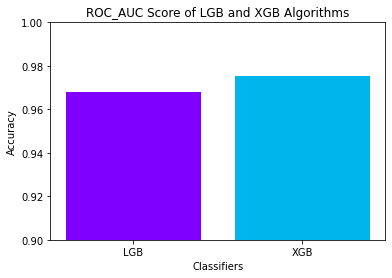

In [ ]:
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 5))
labels = ['LGB', 'XGB']

plt.bar(labels,
        accuracy_scores,
        color = colors)
plt.ylim((0.9,1))
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('ROC_AUC Score of LGB and XGB Algorithms')

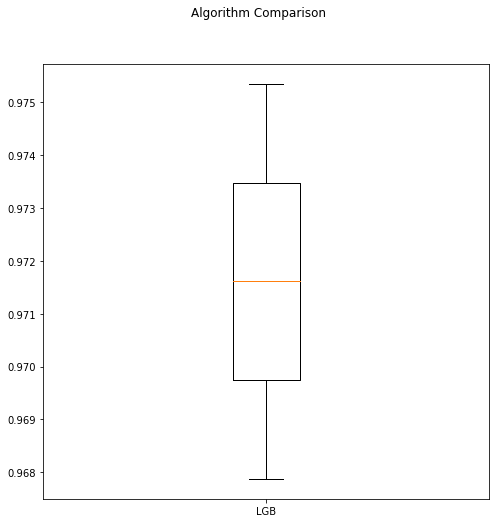

In [ ]:
names=['LGB','XGB']
fig = plt.figure(figsize=(8,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(accuracy_scores,showfliers=False)
ax.set_xticklabels(names)
plt.show()